In [ ]:
from google.colab import drive
drive.mount._DEBUG = False
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Carregue os dados PKLotSegmented.tar.gz para seu Google Drive antes de executar
#Ajuste o path para apontar para o local do arquivo

!mkdir /content/datasets

!tar -xf "/content/drive/MyDrive/mini_siamese_images.tar.xz" -C "/content/datasets"
#Ou, se o .tar.gz já estiver carregado no seu ambiente:
#!tar -xf "/content/mini_siamese_images.tar.xz" -C "/content/datasets"

In [ ]:
import os
import glob
import torch
import random
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from torchvision import models
from torch.utils.data import DataLoader
from PIL import Image
from json import dump
from tqdm import tqdm
from datetime import datetime

In [ ]:
#Definindo loader para triplets
class TripletDataset(Dataset):

    def __init__(self, dataset_map, transform, mode='train'):
        self.__class_images = dataset_map
        self.__mode = mode
        self.__triplets = None
        self.__transform = transform

        self.on_epoch_end()

    def __len__(self):
        return len(self.__triplets)

    def __getitem__(self, idx):
        triplet = self.__triplets[idx]

        img_anchor = self.__transform(Image.open(triplet[0]))
        img_pos = self.__transform(Image.open(triplet[1]))
        img_neg = self.__transform(Image.open(triplet[2]))

        return (img_anchor, img_pos,img_neg)

    #load and shuffle pairs and labels
    def on_epoch_end(self):
        if self.__triplets is not None and self.__mode != 'train':
            return

        print(f"================= {self.__mode} =================")

        self.__triplets = []

        for _ in range(len(self.__class_images)):
            # Select two random objects
            positive_class, negative_class = random.sample(list(self.__class_images.keys()), 2)

            # Select one image from each class
            anchor = self.__class_images[positive_class][0]
            positive = self.__class_images[positive_class][-1]
            negative = random.choice(self.__class_images[negative_class])

            self.__triplets.append((anchor, positive,negative))

        # shuffle
        idx = np.random.permutation(len(self.__triplets))
        self.__triplets = np.array(self.__triplets)[idx]


    def get_pairs_count(self):
        return len(self.__triplets)

In [ ]:
#Definindo backbone e função de treinamento e teste
class MobileNetV3Backbone(torch.nn.Module):
    def __init__(self):
        super(MobileNetV3Backbone, self).__init__()

        self.backbone = models.mobilenet_v3_small(weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        self.features = torch.nn.Sequential(*list(self.backbone.children())[:-1])
        self.pooling = torch.nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        return torch.flatten(x, 1)

class SiameseNetwork(torch.nn.Module):
    def __init__(self, state_dict=None):
        super(SiameseNetwork, self).__init__()
        self.__device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Conectado em um ambiente com", self.__device)
        self.__embedding_network = MobileNetV3Backbone()
        if state_dict:
            self.__embedding_network.load_state_dict(torch.load(state_dict))
        self.__embedding_network = self.__embedding_network.to(self.__device)

    def __euclidean_distance_relu(self, x, y):
        return torch.sqrt(F.relu(torch.sum((x - y) ** 2, dim=1, keepdim=True)))

    def forward(self, input1, input2 = None):
        # O Python é estúpido e não aceita sobrecarga de funções. A gambiarra do if-else é o padrão
        if input2 == None:
            embed = self.__embedding_network(input1)
            return embed
        else:
            tower1 = self.__embedding_network(input1)
            tower2 = self.__embedding_network(input2)
            return self.__euclidean_distance_relu(tower1, tower2)

    def extract_embeddings(self, images):
        return self.__embedding_network(images)


    def train(self, train_map, eval_map, batch_size, epochs, transform, output_dir):
        train_dataset = TripletDataset(train_map, transform)
        eval_dataset = TripletDataset(eval_map, transform, mode='val')

        train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True)
        eval_loader = DataLoader(eval_dataset, batch_size=batch_size,
                                  shuffle=False)

        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        criterion = torch.nn.TripletMarginWithDistanceLoss(margin=0.2, reduction='mean')

        epoch_data = {}
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'Started training')
        for epoch in range(epochs):
            train_dataset.on_epoch_end()
            self.__embedding_network.backbone.train()
            for triplet in train_loader:
                anchor = triplet[0].to(self.__device)
                positive = triplet[1].to(self.__device)
                negative = triplet[2].to(self.__device)

                optimizer.zero_grad()
                anchor_out = self(anchor)
                positive_out = self(positive)
                negative_out = self(negative)
                loss = criterion(anchor_out, positive_out, negative_out)
                loss.backward()
                optimizer.step()

            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'Trained epoch')

            self.__embedding_network.backbone.eval()
            with torch.no_grad():
                epoch_loss = 0
                for triplet in eval_loader:
                    anchor = triplet[0].to(self.__device)
                    positive = triplet[1].to(self.__device)
                    negative = triplet[2].to(self.__device)

                    anchor_out = self(anchor)
                    positive_out = self(positive)
                    negative_out = self(negative)
                    loss = criterion(anchor_out, positive_out, negative_out)

                    epoch_loss += loss.item()

            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'Evaluated epoch')
            epoch_data[epoch+1] = {'validation_loss': epoch_loss}

            print(f'Epoch {epoch+1} loss: {epoch_loss:.5f}')

            with open(f'{output_dir}/best_model_info.json', 'w') as file:
                dump({'epoch': epoch+1, 'validation_loss': epoch_loss}, file)
            torch.save(self.__embedding_network.state_dict(), f'{output_dir}/last_model.pth')

        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'Finished training')

        with open(f'{output_dir}/epoch_data.json', 'w') as file:
            dump(epoch_data, file)

    def evaluate(self, eval_class_dict, batch_size, transform):
        if len(eval_class_dict) <= 1:
            return None

        image_paths = [item for key in eval_class_dict for item in eval_class_dict[key]]

        comparable_to = []
        for i in range(len(eval_class_dict)):
            comparable_to.append(list(range(len(eval_class_dict))))

        emb_dict = {}
        previous_range = 0
        pair_count = 0
        for i, key in enumerate(eval_class_dict):
            pair_count = i
            len_list = len(eval_class_dict[key])

            comparable_to[i].remove(i)

            source_vehicle_index = np.random.randint(previous_range,
                    high=previous_range + len_list)
            source_vehicle_path = image_paths[source_vehicle_index]

            same_vehicle_index = np.random.randint(previous_range,
                    high=previous_range + len_list)
            while same_vehicle_index == source_vehicle_index:
                same_vehicle_index = np.random.randint(previous_range,
                        high=previous_range + len_list)
            same_vehicle_path = image_paths[same_vehicle_index]

            if len(comparable_to[i]) == 0:
                comparable_to[i] = list(range(len(eval_class_dict)))
                comparable_to[i].remove(i)

            different_vehicle = comparable_to[i][np.random.randint(0, len(comparable_to[i]))]
            comparable_to[different_vehicle].remove(i)
            different_vehicle_index = np.random.randint(0,
                    len(eval_class_dict[list(eval_class_dict.keys())[different_vehicle]]))

            emb_dict[i] = {'range': [previous_range, previous_range + len_list],
                    'source_vehicle':
                        {'image_index': source_vehicle_index,
                        'image_path': source_vehicle_path},
                    'same_vehicle':
                        {'image_index': same_vehicle_index,
                        'image_path': same_vehicle_path},
                    'different_vehicle':
                        {'index': different_vehicle,
                        'local_image_index': different_vehicle_index,
                        'image_path': None}}
            previous_range += len_list

        print(f'{pair_count} genuine and impostor pairs generated')
        for key, value in emb_dict.items():
            index = value['different_vehicle']['index']
            local_image_index = value['different_vehicle']['local_image_index']
            value['different_vehicle']['image_path'] = image_paths[emb_dict[index]['range'][0] + local_image_index]

        gt = []
        pred = None

        source_images = []
        same_images = []
        different_images = []
        tested_pairs = []
        imgs_same = []
        imgs_diff = []

        for value in tqdm(emb_dict.values(), desc='Calculating distances...'):
            img_vehicle = Image.open(value['source_vehicle']['image_path'])
            source_images.append(transform(img_vehicle))
            img_same = Image.open(value['same_vehicle']['image_path'])
            same_images.append(transform(img_same))
            img_diff = Image.open(value['different_vehicle']['image_path'])
            different_images.append(transform(img_diff))
            imgs_same.append((img_vehicle,img_same))
            imgs_diff.append((img_same,img_diff))

            if len(source_images) == batch_size:
                source_images = torch.stack(source_images).to(self.__device)
                same_images = torch.stack(same_images).to(self.__device)
                different_images = torch.stack(different_images).to(self.__device)

                if pred is None:
                    pred = self(source_images, same_images).detach().cpu().numpy()
                else:
                    pred = np.concatenate((pred, self(source_images, same_images).detach().cpu().numpy()))
                tested_pairs.extend(imgs_same)
                gt.extend([0] * len(source_images))
                pred = np.concatenate((pred, self(source_images, different_images).detach().cpu().numpy()))
                gt.extend([1] * len(source_images))
                tested_pairs.extend(imgs_diff)

                source_images = []
                same_images = []
                different_images = []

        if len(source_images) > 0:
                source_images = torch.stack(source_images).to(self.__device)
                same_images = torch.stack(same_images).to(self.__device)
                different_images = torch.stack(different_images).to(self.__device)

                pred = np.concatenate((pred, self(source_images, same_images).detach().cpu().numpy()))
                tested_pairs.extend(imgs_same)
                gt.extend([0] * len(source_images))
                pred = np.concatenate((pred, self(source_images, different_images).detach().cpu().numpy()))
                tested_pairs.extend(imgs_diff)
                gt.extend([1] * len(source_images))

        gt = np.array(gt)

        return gt, pred, tested_pairs

In [ ]:
#Funções auxiliares
def save_class_file(class_images, folder_list):
    for folder_path in folder_list:
        image_paths = glob.glob(folder_path + '/*.png')
        if len(image_paths) > 1:
            for file_path in image_paths:
                cls = '_'.join(folder_path.split('/')[-3:])

                if cls not in class_images:
                    class_images[cls] = [file_path]
                else:
                    class_images[cls].append(file_path)

def create_train_image_classes(dataset_train_path, dataset_eval_path):
    train_class_images = {}
     #get only folders with more than 2 images inside
    folders = [folder for folder in glob.glob(dataset_train_path + '/*') if os.path.isdir(folder) and len(os.listdir(folder)) > 2]
    folders.sort()
    print(f'{dataset_train_path} {len(folders)}: train')
    save_class_file(train_class_images, folders)

    eval_class_images = {}
    folders = [folder for folder in glob.glob(dataset_eval_path + '/*') if os.path.isdir(folder) and len(os.listdir(folder)) > 2]
    folders.sort()
    print(f'{dataset_eval_path} {len(folders)}: val')
    save_class_file(eval_class_images, folders)

    return train_class_images, eval_class_images

def create_test_image_classes(dataset_test_path):

    test_class_images = {}
    folders = [folder for folder in glob.glob(dataset_test_path + '/*') if os.path.isdir(folder)]
    folders.sort()
    print(f'{dataset_test_path} {len(folders)}')

    save_class_file(test_class_images, folders)

    return test_class_images

def train_network(dataset_train_path, dataset_eval_path, output_dir,
                  batch_size, epochs, transform):

    train_class_images, eval_class_images = create_train_image_classes(dataset_train_path, dataset_eval_path)

    model = SiameseNetwork()
    model.train(train_class_images, eval_class_images,
                batch_size, epochs, transform, output_dir)

def test_network(dataset_test_path, output_dir, batch_size, transform, threshold):

    eval_class_dict = create_test_image_classes(dataset_test_path)

    model = SiameseNetwork(f'{output_dir}/last_model.pth')

    gt, pred, tested_pairs = model.evaluate(eval_class_dict, batch_size, transform)

    accuracy = (np.array([0 if i < threshold else 1 for i in pred]) == gt)
    accuracy = accuracy.sum() / len(gt)
    print("Num. Test Samples:", len(gt))
    print("Accuracy:", accuracy)

    return gt, np.array([0 if i < threshold else 1 for i in pred]), tested_pairs

def show_test_results(gt, pred, tested_pairs):
    for i in range(len(gt)):
      print("GT:", gt[i], "Resultado:", pred[i])
      display(tested_pairs[i][0])
      display(tested_pairs[i][1])

/content/datasets/mini_siamese_images/PKLot/train/ufpr04 123: train
/content/datasets/mini_siamese_images/PKLot/val/ufpr04 115: val
Conectado em um ambiente com cpu
================= train =================
================= val =================
2024-08-29 13:52:02 Started training
================= train =================
2024-08-29 13:52:08 Trained epoch
2024-08-29 13:52:09 Evaluated epoch
Epoch 1 loss: 0.00000
================= train =================
2024-08-29 13:52:14 Trained epoch
2024-08-29 13:52:15 Evaluated epoch
Epoch 2 loss: 0.00000
================= train =================
2024-08-29 13:52:21 Trained epoch
2024-08-29 13:52:23 Evaluated epoch
Epoch 3 loss: 0.00000
================= train =================
2024-08-29 13:52:28 Trained epoch
2024-08-29 13:52:29 Evaluated epoch
Epoch 4 loss: 0.00000
================= train =================
2024-08-29 13:52:35 Trained epoch
2024-08-29 13:52:36 Evaluated epoch
Epoch 5 loss: 0.00000
================= train =================
2024

<ipython-input-37-5f2fa95293ee>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.__embedding_network.load_state_dict(torch.load(state_dict))


2024-08-29 13:54:17 Evaluated epoch
Epoch 20 loss: 0.01118
2024-08-29 13:54:17 Finished training
/content/datasets/mini_siamese_images/PKLot/test/ufpr05 153
Conectado em um ambiente com cpu
142 genuine and impostor pairs generated


Calculating distances...: 100%|██████████| 143/143 [00:02<00:00, 54.36it/s]


Num. Test Samples: 286
Accuracy: 0.9020979020979021
GT: 0 Resultado: 0


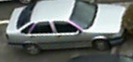

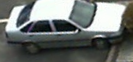

GT: 0 Resultado: 1


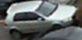

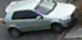

GT: 0 Resultado: 1


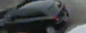

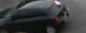

GT: 0 Resultado: 0


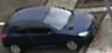

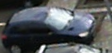

GT: 0 Resultado: 0


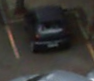

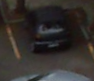

GT: 0 Resultado: 0


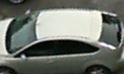

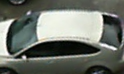

GT: 0 Resultado: 0


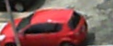

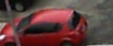

GT: 0 Resultado: 1


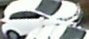

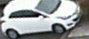

GT: 0 Resultado: 0


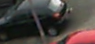

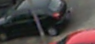

GT: 0 Resultado: 1


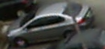

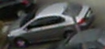

GT: 0 Resultado: 0


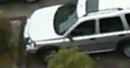

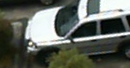

GT: 0 Resultado: 0


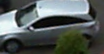

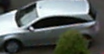

GT: 0 Resultado: 0


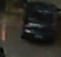

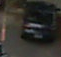

GT: 0 Resultado: 0


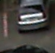

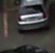

GT: 0 Resultado: 1


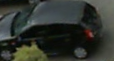

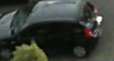

GT: 0 Resultado: 0


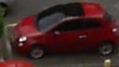

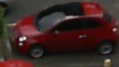

GT: 0 Resultado: 0


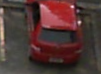

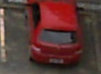

GT: 0 Resultado: 0


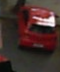

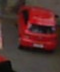

GT: 0 Resultado: 0


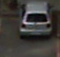

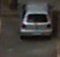

GT: 0 Resultado: 0


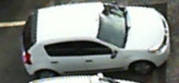

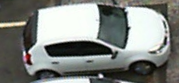

GT: 0 Resultado: 1


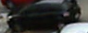

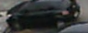

GT: 0 Resultado: 0


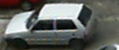

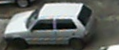

GT: 0 Resultado: 0


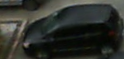

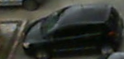

GT: 0 Resultado: 1


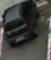

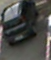

GT: 0 Resultado: 0


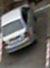

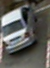

GT: 0 Resultado: 0


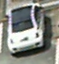

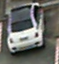

GT: 0 Resultado: 0


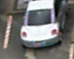

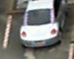

GT: 0 Resultado: 0


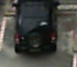

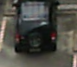

GT: 0 Resultado: 0


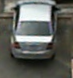

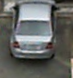

GT: 0 Resultado: 0


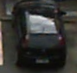

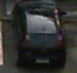

GT: 0 Resultado: 0


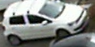

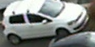

GT: 0 Resultado: 0


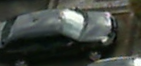

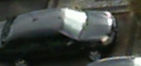

GT: 0 Resultado: 1


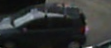

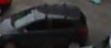

GT: 0 Resultado: 0


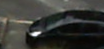

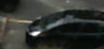

GT: 0 Resultado: 1


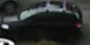

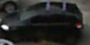

GT: 0 Resultado: 0


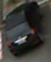

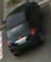

GT: 0 Resultado: 0


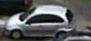

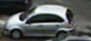

GT: 0 Resultado: 0


GT: 0 Resultado: 1


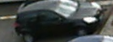

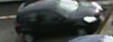

GT: 0 Resultado: 0


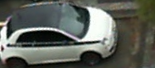

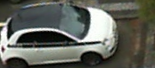

GT: 0 Resultado: 0


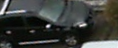

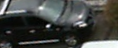

GT: 0 Resultado: 0


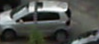

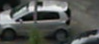

GT: 0 Resultado: 1


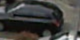

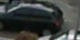

GT: 0 Resultado: 0


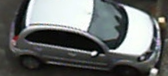

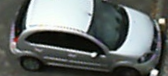

GT: 0 Resultado: 0


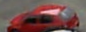

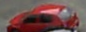

GT: 0 Resultado: 0


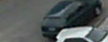

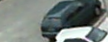

GT: 0 Resultado: 1


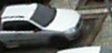

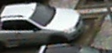

GT: 0 Resultado: 1


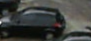

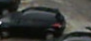

GT: 0 Resultado: 0


GT: 0 Resultado: 1


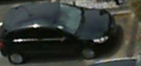

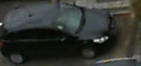

GT: 0 Resultado: 1


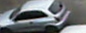

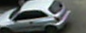

GT: 0 Resultado: 1


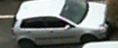

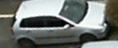

GT: 0 Resultado: 0


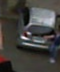

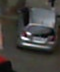

GT: 0 Resultado: 0


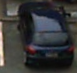

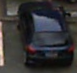

GT: 0 Resultado: 0


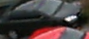

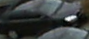

GT: 0 Resultado: 1


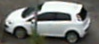

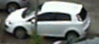

GT: 0 Resultado: 0


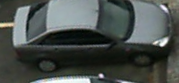

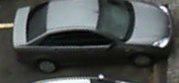

GT: 0 Resultado: 0


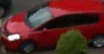

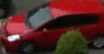

GT: 0 Resultado: 0


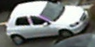

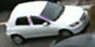

GT: 0 Resultado: 0


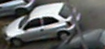

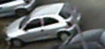

GT: 0 Resultado: 0


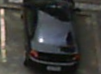

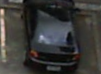

GT: 0 Resultado: 0


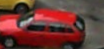

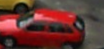

GT: 0 Resultado: 1


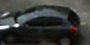

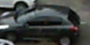

GT: 0 Resultado: 0


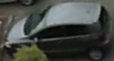

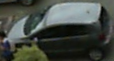

GT: 1 Resultado: 1


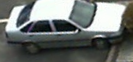

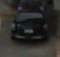

GT: 1 Resultado: 1


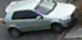

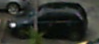

GT: 1 Resultado: 1


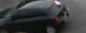

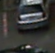

GT: 1 Resultado: 1


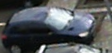

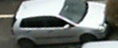

GT: 1 Resultado: 1


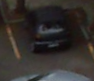

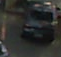

GT: 1 Resultado: 1


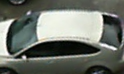

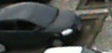

GT: 1 Resultado: 1


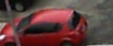

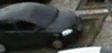

GT: 1 Resultado: 1


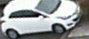

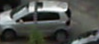

GT: 1 Resultado: 1


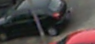

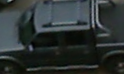

GT: 1 Resultado: 1


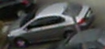

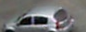

GT: 1 Resultado: 1


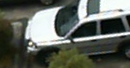

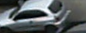

GT: 1 Resultado: 1


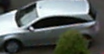

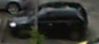

GT: 1 Resultado: 1


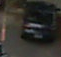

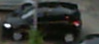

GT: 1 Resultado: 1


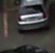

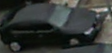

GT: 1 Resultado: 1


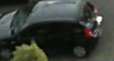

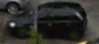

GT: 1 Resultado: 1


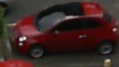

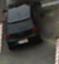

GT: 1 Resultado: 1


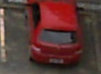

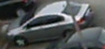

GT: 1 Resultado: 1


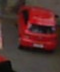

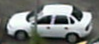

GT: 1 Resultado: 1


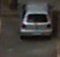

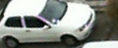

GT: 1 Resultado: 1


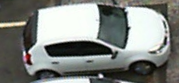

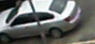

GT: 1 Resultado: 1


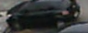

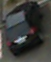

GT: 1 Resultado: 1


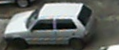

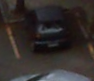

GT: 1 Resultado: 1


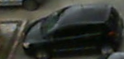

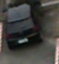

GT: 1 Resultado: 1


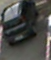

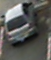

GT: 1 Resultado: 1


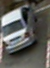

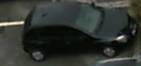

GT: 1 Resultado: 1


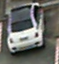

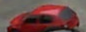

GT: 1 Resultado: 1


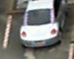

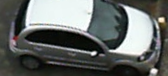

GT: 1 Resultado: 1


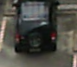

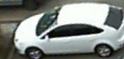

GT: 1 Resultado: 1


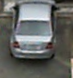

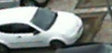

GT: 1 Resultado: 1


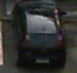

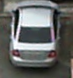

GT: 1 Resultado: 1


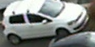

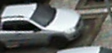

GT: 1 Resultado: 1


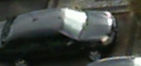

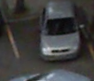

GT: 1 Resultado: 1


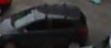

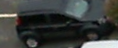

GT: 1 Resultado: 1


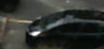

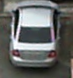

GT: 1 Resultado: 1


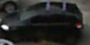

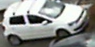

GT: 1 Resultado: 1


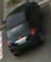

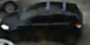

GT: 1 Resultado: 1


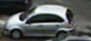

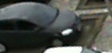

GT: 1 Resultado: 1


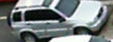

GT: 1 Resultado: 1


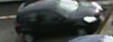

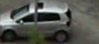

GT: 1 Resultado: 1


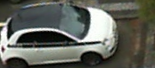

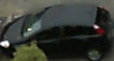

GT: 1 Resultado: 1


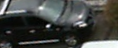

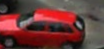

GT: 1 Resultado: 1


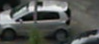

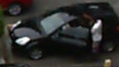

GT: 1 Resultado: 1


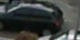

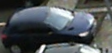

GT: 1 Resultado: 1


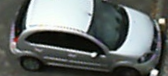

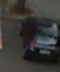

GT: 1 Resultado: 1


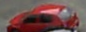

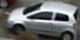

GT: 1 Resultado: 1


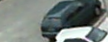

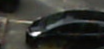

GT: 1 Resultado: 1


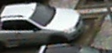

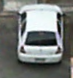

GT: 1 Resultado: 1


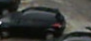

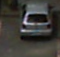

GT: 1 Resultado: 1


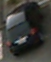

GT: 1 Resultado: 1


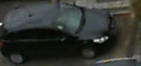

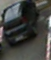

GT: 1 Resultado: 1


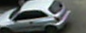

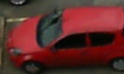

GT: 1 Resultado: 1


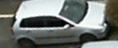

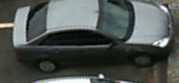

GT: 1 Resultado: 1


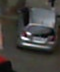

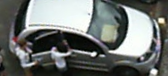

GT: 1 Resultado: 1


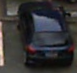

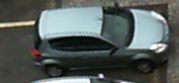

GT: 1 Resultado: 1


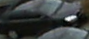

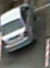

GT: 1 Resultado: 1


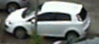

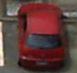

GT: 1 Resultado: 1


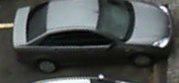

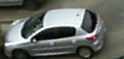

GT: 1 Resultado: 1


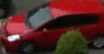

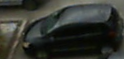

GT: 1 Resultado: 1


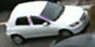

GT: 1 Resultado: 1


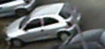

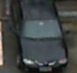

GT: 1 Resultado: 1


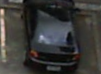

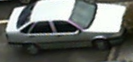

GT: 1 Resultado: 1


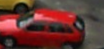

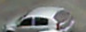

GT: 1 Resultado: 1


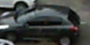

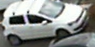

GT: 1 Resultado: 1


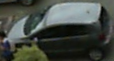

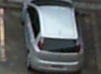

GT: 0 Resultado: 0


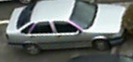

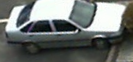

GT: 0 Resultado: 1


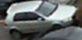

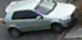

GT: 0 Resultado: 0


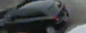

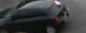

GT: 0 Resultado: 0


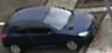

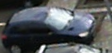

GT: 0 Resultado: 0


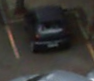

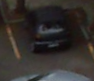

GT: 0 Resultado: 0


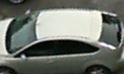

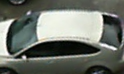

GT: 0 Resultado: 0


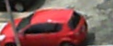

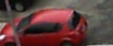

GT: 0 Resultado: 0


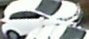

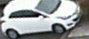

GT: 0 Resultado: 0


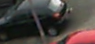

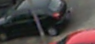

GT: 0 Resultado: 1


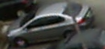

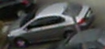

GT: 0 Resultado: 0


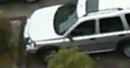

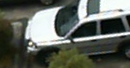

GT: 0 Resultado: 0


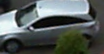

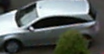

GT: 0 Resultado: 0


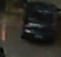

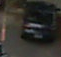

GT: 0 Resultado: 0


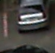

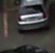

GT: 0 Resultado: 0


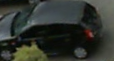

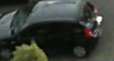

GT: 0 Resultado: 0


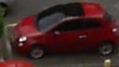

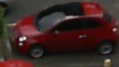

GT: 0 Resultado: 0


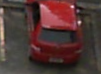

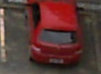

GT: 0 Resultado: 0


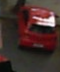

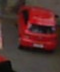

GT: 0 Resultado: 0


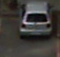

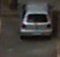

GT: 0 Resultado: 0


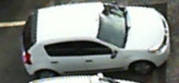

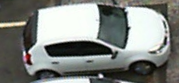

GT: 0 Resultado: 0


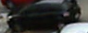

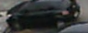

GT: 0 Resultado: 0


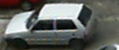

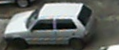

GT: 0 Resultado: 0


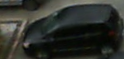

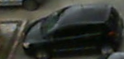

GT: 0 Resultado: 0


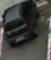

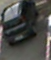

GT: 0 Resultado: 0


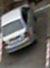

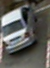

GT: 0 Resultado: 0


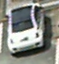

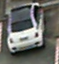

GT: 0 Resultado: 1


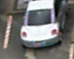

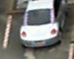

GT: 0 Resultado: 0


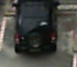

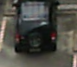

GT: 0 Resultado: 0


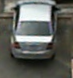

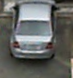

GT: 0 Resultado: 0


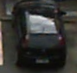

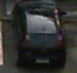

GT: 0 Resultado: 0


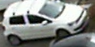

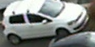

GT: 0 Resultado: 1


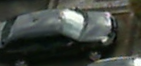

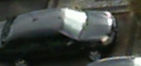

GT: 0 Resultado: 0


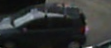

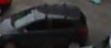

GT: 0 Resultado: 0


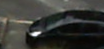

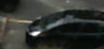

GT: 0 Resultado: 1


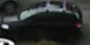

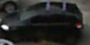

GT: 0 Resultado: 0


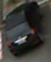

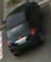

GT: 0 Resultado: 0


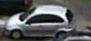

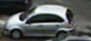

GT: 0 Resultado: 1


GT: 0 Resultado: 0


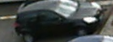

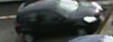

GT: 0 Resultado: 0


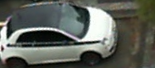

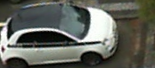

GT: 0 Resultado: 0


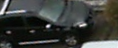

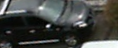

GT: 0 Resultado: 1


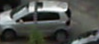

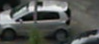

GT: 0 Resultado: 1


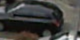

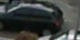

GT: 0 Resultado: 0


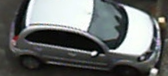

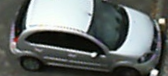

GT: 0 Resultado: 1


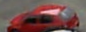

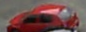

GT: 0 Resultado: 0


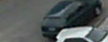

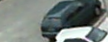

GT: 0 Resultado: 0


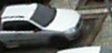

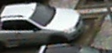

GT: 0 Resultado: 0


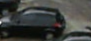

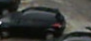

GT: 0 Resultado: 0


GT: 0 Resultado: 0


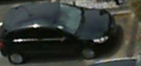

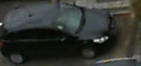

GT: 0 Resultado: 0


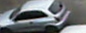

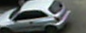

GT: 0 Resultado: 0


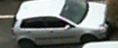

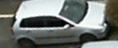

GT: 0 Resultado: 0


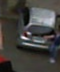

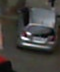

GT: 0 Resultado: 0


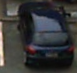

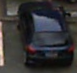

GT: 0 Resultado: 1


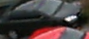

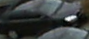

GT: 0 Resultado: 0


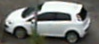

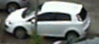

GT: 0 Resultado: 0


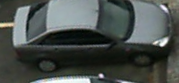

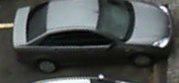

GT: 0 Resultado: 0


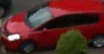

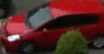

GT: 0 Resultado: 0


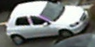

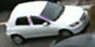

GT: 0 Resultado: 0


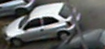

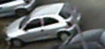

GT: 0 Resultado: 0


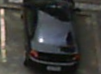

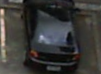

GT: 0 Resultado: 0


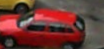

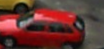

GT: 0 Resultado: 0


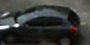

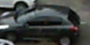

GT: 0 Resultado: 0


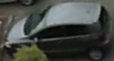

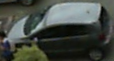

GT: 1 Resultado: 1


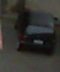

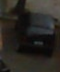

GT: 1 Resultado: 1


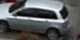

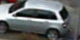

GT: 1 Resultado: 1


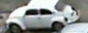

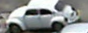

GT: 1 Resultado: 1


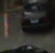

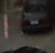

GT: 1 Resultado: 1


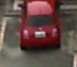

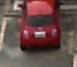

GT: 1 Resultado: 1


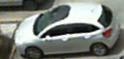

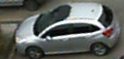

GT: 1 Resultado: 1


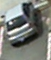

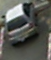

GT: 1 Resultado: 1


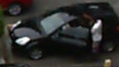

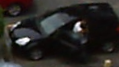

GT: 1 Resultado: 1


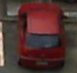

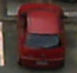

GT: 1 Resultado: 1


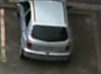

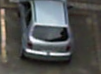

GT: 1 Resultado: 1


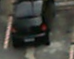

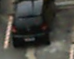

GT: 1 Resultado: 1


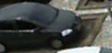

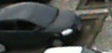

GT: 1 Resultado: 1


GT: 1 Resultado: 1


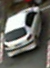

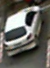

GT: 1 Resultado: 1


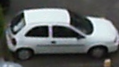

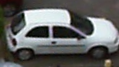

GT: 1 Resultado: 1


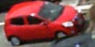

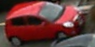

GT: 1 Resultado: 1


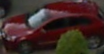

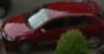

GT: 1 Resultado: 1


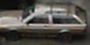

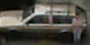

GT: 1 Resultado: 1


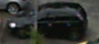

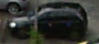

GT: 1 Resultado: 1


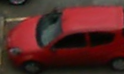

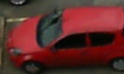

GT: 1 Resultado: 1


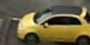

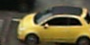

GT: 1 Resultado: 1


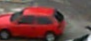

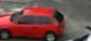

GT: 1 Resultado: 1


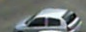

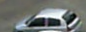

GT: 1 Resultado: 1


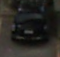

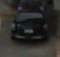

GT: 1 Resultado: 1


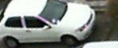

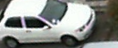

GT: 1 Resultado: 1


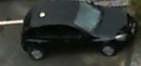

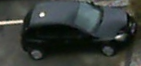

GT: 1 Resultado: 1


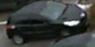

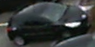

GT: 1 Resultado: 1


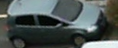

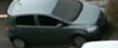

GT: 1 Resultado: 1


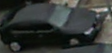

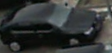

GT: 1 Resultado: 1


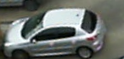

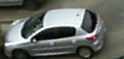

GT: 1 Resultado: 1


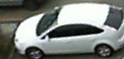

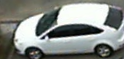

GT: 1 Resultado: 1


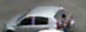

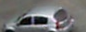

GT: 1 Resultado: 1


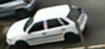

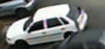

GT: 1 Resultado: 1


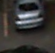

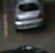

GT: 1 Resultado: 1


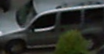

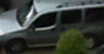

GT: 1 Resultado: 1


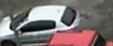

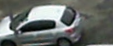

GT: 1 Resultado: 1


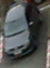

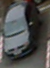

GT: 1 Resultado: 1


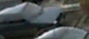

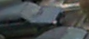

GT: 1 Resultado: 1


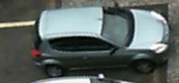

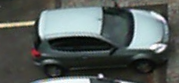

GT: 1 Resultado: 1


GT: 1 Resultado: 1


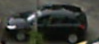

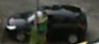

GT: 1 Resultado: 1


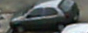

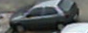

GT: 1 Resultado: 1


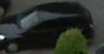

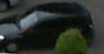

GT: 1 Resultado: 1


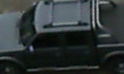

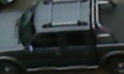

GT: 1 Resultado: 1


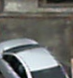

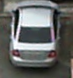

GT: 1 Resultado: 1


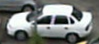

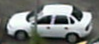

GT: 1 Resultado: 1


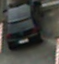

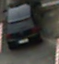

GT: 1 Resultado: 1


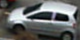

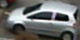

GT: 1 Resultado: 1


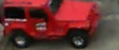

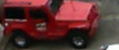

GT: 1 Resultado: 1


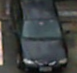

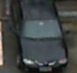

GT: 1 Resultado: 1


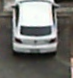

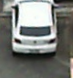

GT: 1 Resultado: 1


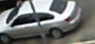

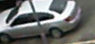

GT: 1 Resultado: 1


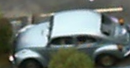

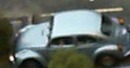

GT: 1 Resultado: 1


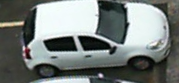

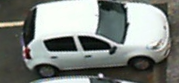

GT: 1 Resultado: 1


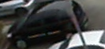

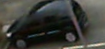

GT: 1 Resultado: 1


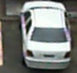

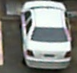

GT: 1 Resultado: 1


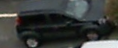

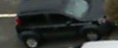

GT: 1 Resultado: 1


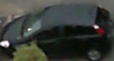

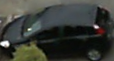

GT: 1 Resultado: 1


GT: 1 Resultado: 1


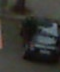

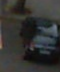

GT: 1 Resultado: 1


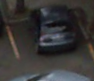

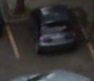

GT: 1 Resultado: 1


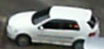

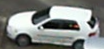

GT: 1 Resultado: 1


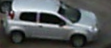

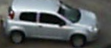

GT: 1 Resultado: 1


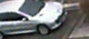

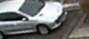

GT: 0 Resultado: 0


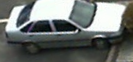

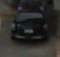

GT: 0 Resultado: 0


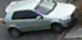

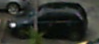

GT: 0 Resultado: 0


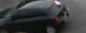

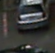

GT: 0 Resultado: 0


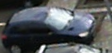

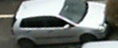

GT: 0 Resultado: 0


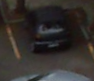

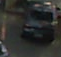

GT: 0 Resultado: 0


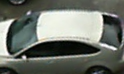

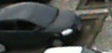

GT: 0 Resultado: 0


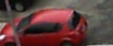

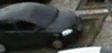

GT: 0 Resultado: 0


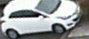

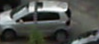

GT: 0 Resultado: 0


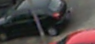

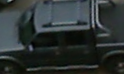

GT: 0 Resultado: 0


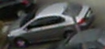

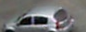

GT: 0 Resultado: 0


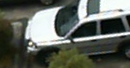

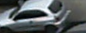

GT: 0 Resultado: 0


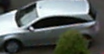

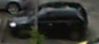

GT: 0 Resultado: 0


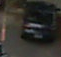

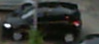

GT: 0 Resultado: 0


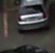

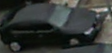

GT: 0 Resultado: 0


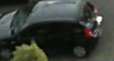

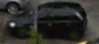

GT: 1 Resultado: 1


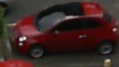

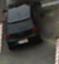

GT: 1 Resultado: 1


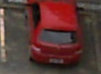

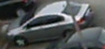

GT: 1 Resultado: 1


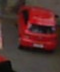

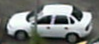

GT: 1 Resultado: 1


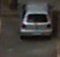

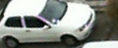

GT: 1 Resultado: 1


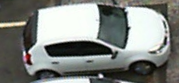

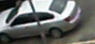

GT: 1 Resultado: 1


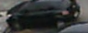

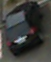

GT: 1 Resultado: 1


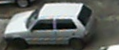

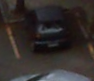

GT: 1 Resultado: 1


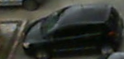

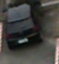

GT: 1 Resultado: 1


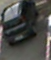

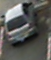

GT: 1 Resultado: 1


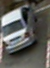

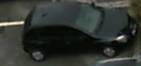

GT: 1 Resultado: 1


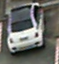

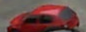

GT: 1 Resultado: 1


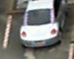

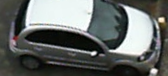

GT: 1 Resultado: 1


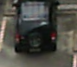

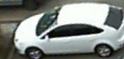

GT: 1 Resultado: 1


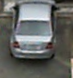

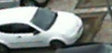

GT: 1 Resultado: 1


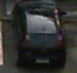

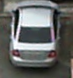

In [ ]:
dataset_train_path = '/content/datasets/mini_siamese_images/PKLot/train/ufpr04'
dataset_eval_path = '/content/datasets/mini_siamese_images/PKLot/val/ufpr04'
dataset_test_path = '/content/datasets/mini_siamese_images/PKLot/test/ufpr05'
output_dir = '.'
batch_size = 64
epochs = 20
input_shape = (128, 128)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize(input_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])


train_network(dataset_train_path, dataset_eval_path, output_dir, batch_size, epochs, transform)

#Chute, precisa calcular pelo EER
threshold = 10

gt, pred, tested_pairs = test_network(dataset_test_path, output_dir, batch_size, transform, threshold)
show_test_results(gt, pred, tested_pairs)